In [51]:
# !pip install opencv-python
# !pip install numpy
# !pip install mediapipe opencv-python
# !pip install pandas
# !pip install xmltodict
# !pip install lxml

In [52]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
import os

## openpose 모델로드 및 gpu 설정

In [53]:
device = "gpu" # please change it to "gpu" if the model needs to be run on cuda.

protoFile = "pose_deploy_linevec.prototxt"
weightsFile = "pose_iter_440000.caffemodel"
nPoints = 18
# COCO Output Format
keypointsMapping = ['Nose', 'Neck', 'R-Sho', 'R-Elb', 'R-Wr', 'L-Sho', 
                    'L-Elb', 'L-Wr', 'R-Hip', 'R-Knee', 'R-Ank', 'L-Hip', 
                    'L-Knee', 'L-Ank', 'R-Eye', 'L-Eye', 'R-Ear', 'L-Ear']

POSE_PAIRS = [[1,2], [1,5], [2,3], [3,4], [5,6], [6,7],
              [1,8], [8,9], [9,10], [1,11], [11,12], [12,13],
              [1,0], [0,14], [14,16], [0,15], [15,17],
              [2,17], [5,16] ]

# index of pafs correspoding to the POSE_PAIRS
# e.g for POSE_PAIR(1,2), the PAFs are located at indices (31,32) of output, Similarly, (1,5) -> (39,40) and so on.
mapIdx = [[31,32], [39,40], [33,34], [35,36], [41,42], [43,44], 
          [19,20], [21,22], [23,24], [25,26], [27,28], [29,30], 
          [47,48], [49,50], [53,54], [51,52], [55,56], 
          [37,38], [45,46]]

colors = [ [0,100,255], [0,100,255], [0,255,255], [0,100,255], [0,255,255], [0,100,255],
         [0,255,0], [255,200,100], [255,0,255], [0,255,0], [255,200,100], [255,0,255],
         [0,0,255], [255,0,0], [200,200,0], [255,0,0], [200,200,0], [0,0,0]]

net = cv2.dnn.readNetFromCaffe(protoFile, weightsFile)

if device == "cpu":
    net.setPreferableBackend(cv2.dnn.DNN_TARGET_CPU)
    print("Using CPU device")
elif device == "gpu":
    net.setPreferableBackend(cv2.dnn.DNN_BACKEND_CUDA)
    net.setPreferableTarget(cv2.dnn.DNN_TARGET_CUDA)
    print("Using GPU device")

Using GPU device


## openpose 함수

In [54]:
# Find the Keypoints using Non Maximum Suppression on the Confidence Map
def getKeypoints(probMap, threshold=0.1):
    
    mapSmooth = cv2.GaussianBlur(probMap,(3,3),0,0)

    mapMask = np.uint8(mapSmooth>threshold)
    keypoints = []
    
    #find the blobs
    contours, _ = cv2.findContours(mapMask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    #for each blob find the maxima
    for cnt in contours:
        blobMask = np.zeros(mapMask.shape)
        blobMask = cv2.fillConvexPoly(blobMask, cnt, 1)
        maskedProbMap = mapSmooth * blobMask
        _, maxVal, _, maxLoc = cv2.minMaxLoc(maskedProbMap)
        keypoints.append(maxLoc + (probMap[maxLoc[1], maxLoc[0]],))

    return keypoints

# Find valid connections between the different joints of a all persons present
def getValidPairs(output):
    valid_pairs = []
    invalid_pairs = []
    n_interp_samples = 10
    paf_score_th = 0.1
    conf_th = 0.7
    # loop for every POSE_PAIR
    for k in range(len(mapIdx)):
        # A->B constitute a limb
        pafA = output[0, mapIdx[k][0], :, :]
        pafB = output[0, mapIdx[k][1], :, :]
        pafA = cv2.resize(pafA, (frameWidth, frameHeight))
        pafB = cv2.resize(pafB, (frameWidth, frameHeight))

        # Find the keypoints for the first and second limb
        candA = detected_keypoints[POSE_PAIRS[k][0]]
        candB = detected_keypoints[POSE_PAIRS[k][1]]
        nA = len(candA)
        nB = len(candB)

        # If keypoints for the joint-pair is detected
        # check every joint in candA with every joint in candB 
        # Calculate the distance vector between the two joints
        # Find the PAF values at a set of interpolated points between the joints
        # Use the above formula to compute a score to mark the connection valid
        
        if( nA != 0 and nB != 0):
            valid_pair = np.zeros((0,3))
            for i in range(nA):
                max_j=-1
                maxScore = -1
                found = 0
                for j in range(nB):
                    # Find d_ij
                    d_ij = np.subtract(candB[j][:2], candA[i][:2])
                    norm = np.linalg.norm(d_ij)
                    if norm:
                        d_ij = d_ij / norm
                    else:
                        continue
                    # Find p(u)
                    interp_coord = list(zip(np.linspace(candA[i][0], candB[j][0], num=n_interp_samples),
                                            np.linspace(candA[i][1], candB[j][1], num=n_interp_samples)))
                    # Find L(p(u))
                    paf_interp = []
                    for k in range(len(interp_coord)):
                        paf_interp.append([pafA[int(round(interp_coord[k][1])), int(round(interp_coord[k][0]))],
                                           pafB[int(round(interp_coord[k][1])), int(round(interp_coord[k][0]))] ]) 
                    # Find E
                    paf_scores = np.dot(paf_interp, d_ij)
                    avg_paf_score = sum(paf_scores)/len(paf_scores)
                    
                    # Check if the connection is valid
                    # If the fraction of interpolated vectors aligned with PAF is higher then threshold -> Valid Pair  
                    if ( len(np.where(paf_scores > paf_score_th)[0]) / n_interp_samples ) > conf_th :
                        if avg_paf_score > maxScore:
                            max_j = j
                            maxScore = avg_paf_score
                            found = 1
                # Append the connection to the list
                if found:            
                    valid_pair = np.append(valid_pair, [[candA[i][3], candB[max_j][3], maxScore]], axis=0)

            # Append the detected connections to the global list
            valid_pairs.append(valid_pair)
        else: # If no keypoints are detected
            print("No Connection : k = {}".format(k))
            invalid_pairs.append(k)
            valid_pairs.append([])
    print(valid_pairs)
    return valid_pairs, invalid_pairs

# This function creates a list of keypoints belonging to each person
# For each detected valid pair, it assigns the joint(s) to a person
# It finds the person and index at which the joint should be added. This can be done since we have an id for each joint
def getPersonwiseKeypoints(valid_pairs, invalid_pairs):
    # the last number in each row is the overall score 
    personwiseKeypoints = -1 * np.ones((0, 19))

    for k in range(len(mapIdx)):
        if k not in invalid_pairs:
            partAs = valid_pairs[k][:,0]
            partBs = valid_pairs[k][:,1]
            indexA, indexB = np.array(POSE_PAIRS[k])

            for i in range(len(valid_pairs[k])): 
                found = 0
                person_idx = -1
                for j in range(len(personwiseKeypoints)):
                    if personwiseKeypoints[j][indexA] == partAs[i]:
                        person_idx = j
                        found = 1
                        break

                if found:
                    personwiseKeypoints[person_idx][indexB] = partBs[i]
                    personwiseKeypoints[person_idx][-1] += keypoints_list[partBs[i].astype(int), 2] + valid_pairs[k][i][2]

                # if find no partA in the subset, create a new subset
                elif not found and k < 17:
                    row = -1 * np.ones(19)
                    row[indexA] = partAs[i]
                    row[indexB] = partBs[i]
                    # add the keypoint_scores for the two keypoints and the paf_score 
                    row[-1] = sum(keypoints_list[valid_pairs[k][i,:2].astype(int), 2]) + valid_pairs[k][i][2]
                    personwiseKeypoints = np.vstack([personwiseKeypoints, row])
    return personwiseKeypoints

## 폴더생성

In [55]:
#name 폴더 만들기
def make_dir(root_dir, dir_name):
    folder_list = []
    for i in dir_name:
        try: 
            if i not in folder_list:
                print("{0}/{1}".format(root_dir, i))
                os.makedirs("{0}/{1}".format(root_dir, i))
                folder_list.append(dir_name)

        except:
            pass
    return folder_list

## 파일 검색

In [56]:
import pathlib
import os
import ntpath

def find_file_fullname(fileDir):
    file_name = []
    for name in os.listdir(fileDir):
        file_name.append(name)
    return file_name

## csv 쓰기

## 영상 처리

In [61]:
#cap = cv2.VideoCapture(0)
#cap = cv2.imread("C:/Users/BVer/are_you_ok/img/pose4.jpg")
# root_dir = "C:/Users/BVer/are_you_ok"
# vid_dir = "/video"

def video_preprocessing(root_dir, vid_dir, video_path, action_name):
    cap = cv2.VideoCapture(video_path)
    framenumber = 0
    while cap.isOpened():
        data = []
        ret, img = cap.read()
        if ret == False:
            break
        image1 = cv2.flip(img, 1)
        # image1 = cv2.imread('C:/Users/BVer/are_you_o/img/5579.jpg')
        frameWidth = image1.shape[1]
        frameHeight = image1.shape[0]

        if action_name == 'punching':
            idx = 0
        elif action_name == 'pushing':
            idx = 1
        elif action_name == 'kicking':
            idx = 2
        elif action_name == 'tread':
            idx = 3

        t = time.time()

        # Fix the input Height and get the width according to the Aspect Ratio
        inHeight = 368
        inWidth = int((inHeight/frameHeight)*frameWidth)
        inpBlob = cv2.dnn.blobFromImage(image1, 1.0 / 255, (inWidth, inHeight), (0, 0, 0), swapRB=False, crop=False)

        net.setInput(inpBlob)
        output = net.forward()
        print("Time Taken = {}".format(time.time() - t))

        i = 0
        probMap = output[0, i, :, :]
        probMap = cv2.resize(probMap, (frameWidth, frameHeight))
        # plt.figure(figsize=[14,10])
        # plt.imshow(cv2.cvtColor(image1, cv2.COLOR_BGR2RGB))
        # plt.imshow(probMap, alpha=0.6)
        # plt.colorbar()
        # plt.axis("off")

        detected_keypoints = []
        keypoints_list = np.zeros((0,3))
        keypoint_id = 0
        threshold = 0.1

        for part in range(nPoints):
            probMap = output[0,part,:,:]
            probMap = cv2.resize(probMap, (image1.shape[1], image1.shape[0]))
        #     plt.figure()
        #     plt.imshow(255*np.uint8(probMap>threshold))
            keypoints = getKeypoints(probMap, threshold)
    #         print("Keypoints - {} : {}".format(keypointsMapping[part], keypoints))
            keypoints_with_id = []
            for i in range(len(keypoints)):
                keypoints_with_id.append(keypoints[i] + (keypoint_id,))
                keypoints_list = np.vstack([keypoints_list, keypoints[i]])
                keypoint_id += 1

            detected_keypoints.append(keypoints_with_id)


        # if result.pose_landmarks is not None:
        # for res in detected_keypoints:    
        joint = np.zeros((18, 3))
        for j in range(0, len(detected_keypoints)):
            try:
                joint[j] = [detected_keypoints[j][0][0], detected_keypoints[j][0][1], detected_keypoints[j][0][2]]
            except:
                pass

        # Compute angles between joints
        v1 = joint[[0, 1, 1, 2, 3, 5, 6, 1, 8, 9, 1, 11, 12], :3] # Parent joint
        v2 = joint[[1, 2, 5, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13], :3] # Child joint
        v = v2 - v1 # [20, 3]
        # Normalize v
        v = v / np.linalg.norm(v, axis=1)[:, np.newaxis]

        # Get angle using arcos of dot product
        angle = np.arccos(np.einsum('nt,nt->n',
            v[[0, 0, 1, 3, 2, 5, 1, 7, 8, 2, 10, 11],:], 
            v[[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],:])) # [15,]

        angle = np.degrees(angle) # Convert radian to degree

        angle_label = np.array([angle], dtype=np.float32)
        angle_label = np.append(angle_label, idx)

        d = np.concatenate([joint.flatten(), angle_label])

        data.append(d)        
        
    data = np.array(data)
    np.save(os.path.join('preprocessing/'+ action_name, f'raw_{action_name}_{video_name}'), data)

    # Create sequence data
    seq_length = 30
    full_seq_data = []
    for seq in range(len(data) - seq_length):
        full_seq_data.append(data[seq:seq + seq_length])

    full_seq_data = np.array(full_seq_data)
    #     print(action_name, full_seq_data.shape)
    np.save(os.path.join('preprocessing/'+ action_name, f'seq_{action_name}_{video_name}'), full_seq_data)

    framenumber += 1

    cap.release()
    cv2.destroyAllWindows()
    

## 실행

['kicking']
./preprocessing/kicking
preprocessing start
['kicking1.mp4']
Time Taken = 1.6921005249023438


NameError: name 'frameWidth' is not defined

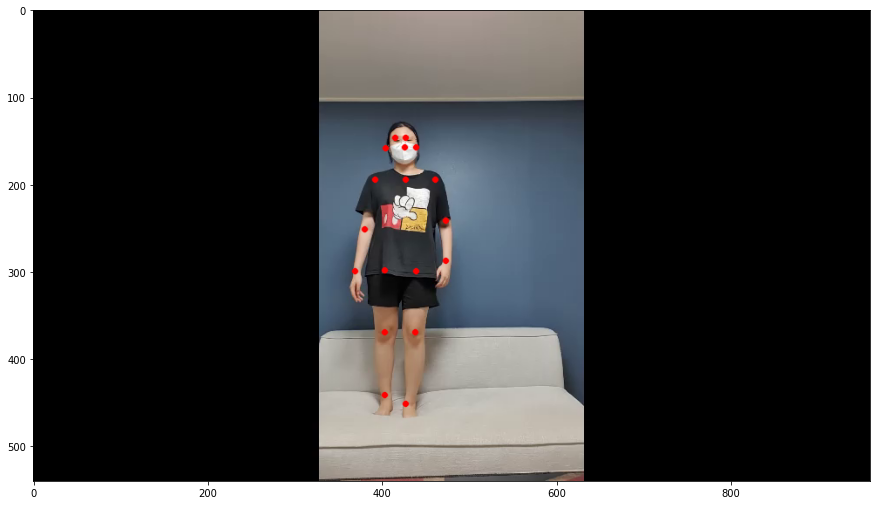

In [62]:
now = '/'
root_dir = 'C:/Users/chltp/detect_video'
video_dir = root_dir + '/datavideo' + now

try: #name 폴더 만들기
    os.makedirs("./preprocessing" + now)
except:
    pass

action_list = []
action_list = find_file_fullname(video_dir)
print(action_list)
make_dir("./preprocessing", action_list)

print('preprocessing start')
for name in action_list:
    video_name = []
    video_name = find_file_fullname(video_dir+name)
    print(video_name)
    save_path = "./preprocessing/"+ name
    for i in video_name:
        video_path=video_dir+name+now+i
        video_preprocessing(root_dir, video_dir, video_path, name)
        print(video_path)

print('----- finish -----')